<a href="https://colab.research.google.com/github/tulasiram58827/plot_top_losses_keras/blob/master/Plot_Top_Losses_Keras_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook authors:
- [tulasiram58827](http://github.com/tulasiram58827)
- [sayakpaul](http://github.com/sayakpaul)

## Initial setup

In [2]:
# Import TensorFlow and check its version
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
# Other imports
from tensorflow.keras import models, layers, datasets
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np

# Fix the random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
# Install wandb
!pip install wandb -q
!wandb login

## Data collection and preparation

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0 # Scale the pixel values to [0,1] range

In [7]:
# Add a channel dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Model definition

In [0]:
# Define the model
def get_training_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
              metrics=['accuracy'])
    
    return model

In [9]:
model = get_training_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Model training sanity check

In [10]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

Epoch 1/4
1875/1875 [==============================] - 11s 6ms/step - loss: 1.6204 - accuracy: 0.8426 - val_loss: 1.5698 - val_accuracy: 0.8908
Epoch 2/4
1875/1875 [==============================] - 11s 6ms/step - loss: 1.5105 - accuracy: 0.9509 - val_loss: 1.4861 - val_accuracy: 0.9756
Epoch 3/4
1875/1875 [==============================] - 11s 6ms/step - loss: 1.4811 - accuracy: 0.9805 - val_loss: 1.4760 - val_accuracy: 0.9853
Epoch 4/4
1875/1875 [==============================] - 11s 6ms/step - loss: 1.4781 - accuracy: 0.9833 - val_loss: 1.4822 - val_accuracy: 0.9788


In [12]:
test_pred = model.predict(test_images)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(test_labels,test_pred).numpy()
print(loss_values, len(loss_values))

[1.4611502 1.4611502 1.46115   ... 1.46115   2.071598  1.4611502] 10000


## Function to plot the images from the test set that cause the top losses

In [0]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
  loss_values = loss(actual,pred).numpy()
  top_k = loss_values.argsort()[-k:][::-1]
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig,axes = plt.subplots(rows, cols, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
  i =0
  for index in top_k:
    image = test_images[index]
    actual = test_labels[index]
    loss_value = loss_values[index]
    predicted = np.argmax(pred[index])
    prob = pred[index][predicted]
    title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
    ax = axes.flat[i]
    i+=1
    image = np.squeeze(image,axis=2)
    ax.imshow(image)
    ax.set_title(title)

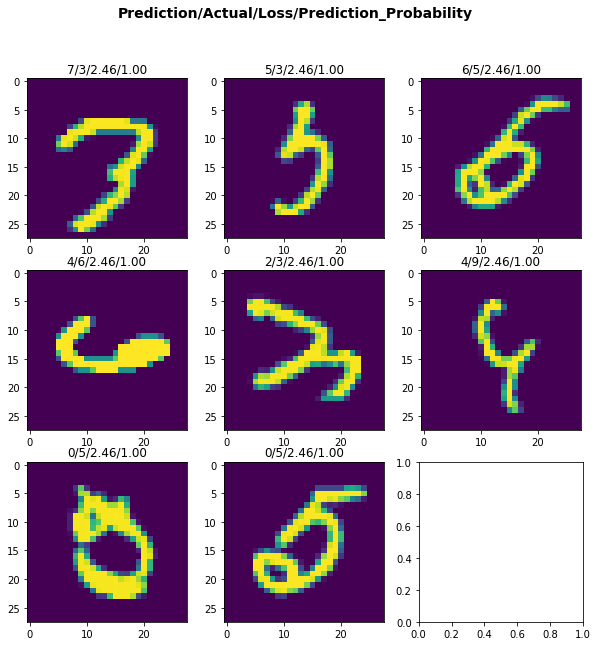

In [14]:
plot_top_losses(test_labels,test_pred,k=8)

## Creating a callback that implements the above for train dataset

In [15]:
import wandb

wandb.init(project="plot-top-losses", id="mnist-demo")

W&B Run: https://app.wandb.ai/sayakpaul/plot-top-losses/runs/mnist-demo

In [0]:
class PlotTopLosses(tf.keras.callbacks.Callback):
    def __init__(self, k=3, frequency=2):
        self.k = k
        self.freq = frequency
        super(PlotTopLosses, self).__init__()
    def on_epoch_begin(self, epoch, logs=None):
        self.top_loss = defaultdict(list)
    def on_epoch_end(self, epoch, logs=None):
      if epoch%self.freq == 0:
          train_pred = self.model.predict(train_images)
          loss_values = self.model.loss(train_labels,train_pred).numpy()
          top_k = loss_values.argsort()[-self.k:][::-1]
          for index in top_k:
              actual_class = train_labels[index]
              loss_value = loss_values[index]
              predicted_class = np.argmax(train_pred[index])
              prob = train_pred[index][predicted_class]
              self.top_loss[epoch,index].append([predicted_class,actual_class,loss_value,prob])
          self.plot_losses(epoch)

    def plot_losses(self, epoch, figsize=(10, 10)):
        cols = math.ceil(math.sqrt(self.k))
        rows = math.ceil(self.k/cols)
        fig,axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle('Prediction/Actual/Loss/Prediction_Probability/epoch', weight='bold', size=14)
        
        i = 0

        for ((epoch,index), plot_stuff) in self.top_loss.items():
            # Unpack the values
            image = train_images[index]
            actual_label = train_labels[index]
            loss_value = plot_stuff[0][2]
            predicted = plot_stuff[0][0]
            prob = plot_stuff[0][3]

            # Prepare the plot
            title = f'{predicted}/{actual_label}/{loss_value:.2f}/{prob:.2f}/{epoch}'
            ax = axes.flat[i]
            i+=1
            image = np.squeeze(image,axis=2)
            ax.imshow(image)
            ax.set_title(title)

        wandb.log({"top_losses": fig})

Epoch 1/4
1875/1875 [==============================] - 15s 8ms/step - loss: 1.6399 - accuracy: 0.8223 - val_loss: 1.5842 - val_accuracy: 0.8765
Epoch 2/4
1875/1875 [==============================] - 13s 7ms/step - loss: 1.4972 - accuracy: 0.9642 - val_loss: 1.4753 - val_accuracy: 0.9861
Epoch 3/4
1875/1875 [==============================] - 12s 7ms/step - loss: 1.4793 - accuracy: 0.9820 - val_loss: 1.4792 - val_accuracy: 0.9822
Epoch 4/4
1875/1875 [==============================] - 12s 7ms/step - loss: 1.4755 - accuracy: 0.9860 - val_loss: 1.4735 - val_accuracy: 0.9879


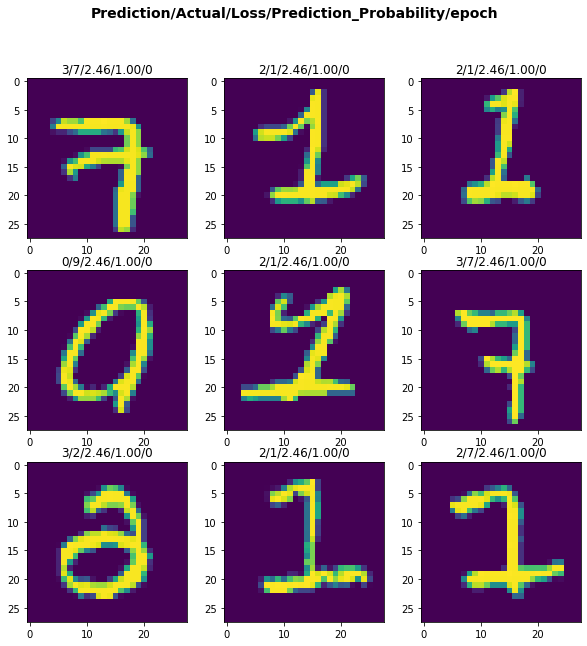

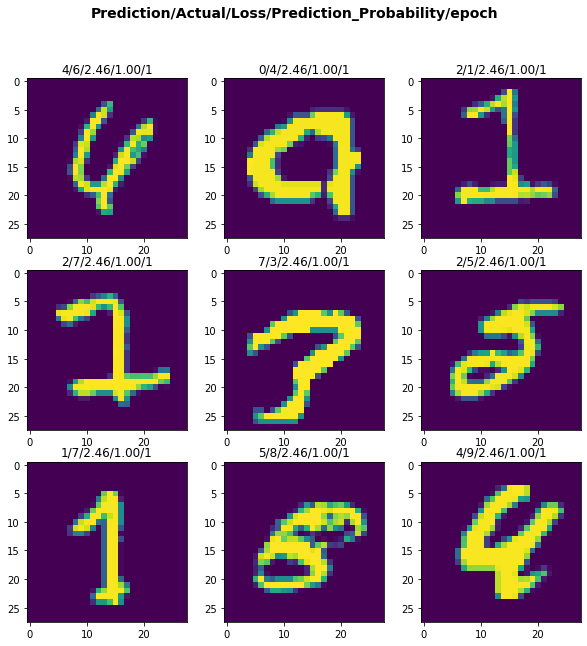

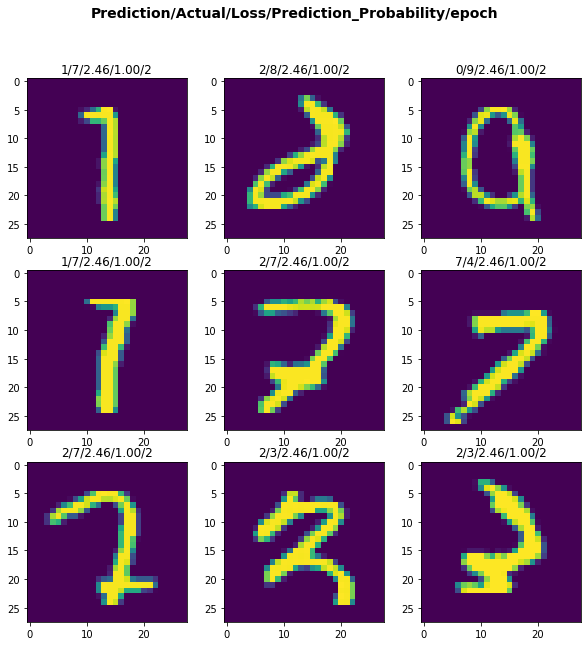

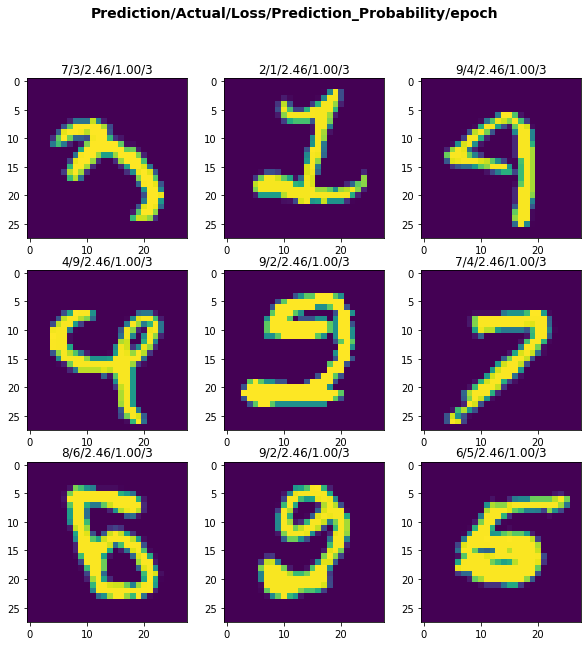

In [17]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1)])

Epoch 1/4
1875/1875 [==============================] - 14s 8ms/step - loss: 1.5872 - accuracy: 0.8757 - val_loss: 1.4923 - val_accuracy: 0.9702
Epoch 2/4
1875/1875 [==============================] - 13s 7ms/step - loss: 1.4854 - accuracy: 0.9761 - val_loss: 1.4766 - val_accuracy: 0.9842
Epoch 3/4
1875/1875 [==============================] - 12s 7ms/step - loss: 1.4800 - accuracy: 0.9813 - val_loss: 1.4786 - val_accuracy: 0.9826
Epoch 4/4
1875/1875 [==============================] - 12s 7ms/step - loss: 1.4779 - accuracy: 0.9834 - val_loss: 1.4803 - val_accuracy: 0.9808


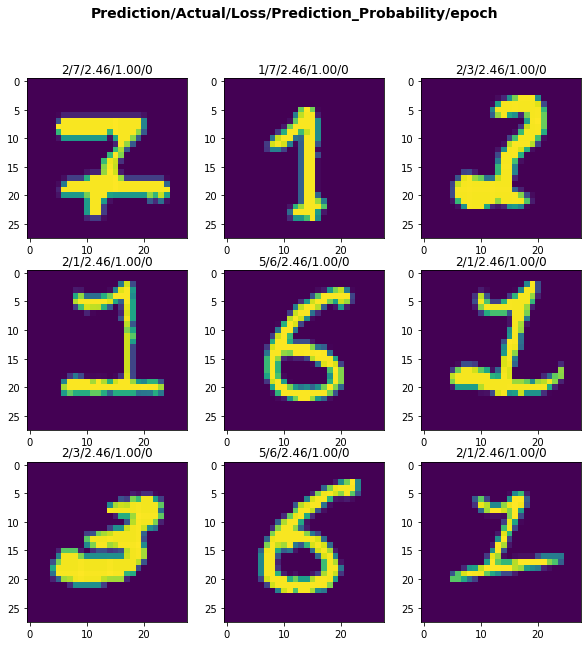

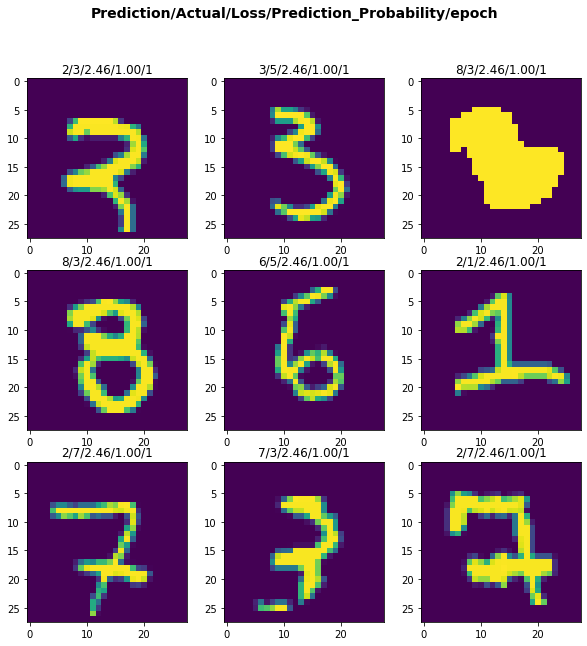

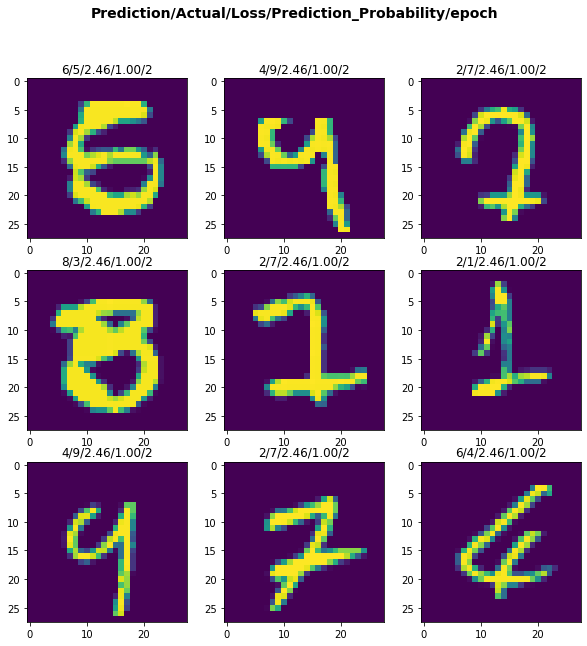

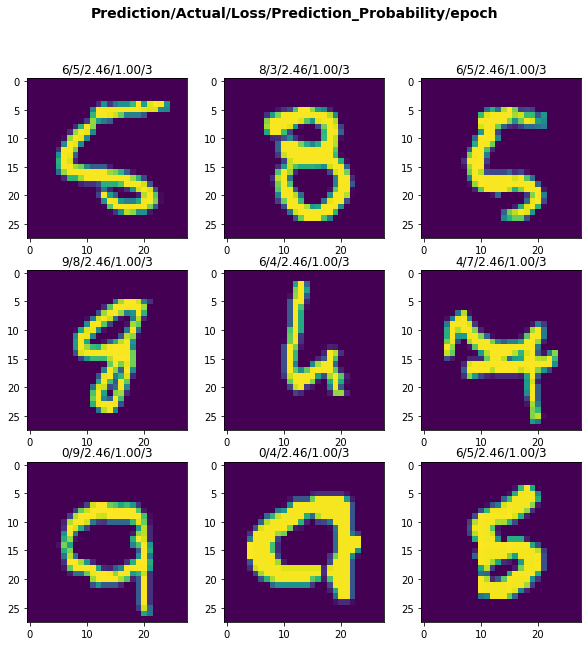

In [18]:
wandb.init(project="plot-top-losses", id="mnist-demo-kerascallback")
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9, frequency=1),
                               wandb.keras.WandbCallback()])